In [1]:
import numpy as np
import pandas as pd
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
%run ./handler/lstm_handler.ipynb

In [349]:
fields = ['VMAX','MSLP','LAT','LON','CD20','COHC','DTL','OAGE','RSST','U200','U20C','V20C','E000','RHLO','RHMD','RHHI',
          'PSLV','PSLV1','PSLV2','Z850','D200','REFC','PEFC','T000','R000', 'TWAC','G150','G200','G250',
          'V000','V850','V500','V300','TGRD','TADV','PENC','SHDC','SDDC','SHGC','DIVC','T150','T200','T250','SHRD',
          'SHTD','SHRS','SHTS','SHRG','PENV','VMPI','VMFX','HE05','O500','O700','CFLX']

class Norm():
    def __init__(self):
        self.scaler = preprocessing.MinMaxScaler()
    
    def normalize_data(self, df_train, df_val, df_test):
        tr = df_train.copy(deep=True)
        va = df_val.copy(deep=True)
        te = df_test.copy(deep=True)
        
        a = train_data[fields].values
        b = val_data[fields].values
        c = test_data[fields].values

        a = self.scaler.fit_transform(a)
        b = self.scaler.transform(b)
        c = self.scaler.transform(c)
        
        tr.loc[:, fields] = a
        va.loc[:, fields] = b
        te.loc[:, fields] = c
        return tr, va, te
    
    def unnormalize(self, data):
        scale = preprocessing.MinMaxScaler()
        scale.min_, scale.scale_ = self.scaler.min_[2:4], self.scaler.scale_[2:4]
        return scale.inverse_transform(data)


def split_data(data, storm_list, train_percent, val_percent, test_percent):
    storm_size = len(storm_list)
    train_size = int(storm_size * train_percent)
    train_ids = storm_list[:train_size]
    val_size = int(storm_size * val_percent)
    val_ids = storm_list[train_size:(train_size + val_size)]
    test_ids = storm_list[(train_size + val_size):]
    train_data = data.loc[data['ID'].isin(train_ids)]
    val_data = data.loc[data['ID'].isin(val_ids)]
    test_data = data.loc[data['ID'].isin(test_ids)]
    return train_data, val_data, test_data, train_ids, val_ids, test_ids

def get_model_data(storm_ids, data):
    # Getting 
    st_labels = []
    st_data = []
    storms_labels = []
    storms_data = []
    
    for storm in storm_ids:
        df_temp = data.loc[data.ID == storm]
        df_temp = df_temp.sort_values(by=['DATETIME'])
        df_temp.reset_index(drop=True, inplace=True)
        # Create df_temp copy for storm labels
        df_temp2 = df_temp.copy(deep=True)
        # Shift left Latitude and Longitude by 1 Time Step from Index 2 for labels
#         df_temp.iloc[1:, [8, 9]] = df_temp.iloc[:-1, [8, 9]].values
        df_temp2.iloc[:-1, [8, 9]] = df_temp2.iloc[1:, [8, 9]].values
        
        for x in range(len(df_temp)):
            storm_series = df_temp.loc[x, fields]
            storm_location = df_temp2.loc[x, ['LAT', 'LON']]
            st_data.append(storm_series)
            st_labels.append(storm_location)
        for y in range(89 - len(st_data)):
            zeros = [0] * 55
            zeros_labels = [0] * 2
            st_data.append(zeros)
            st_labels.append(zeros_labels)
        storms_data.append(st_data)
        storms_labels.append(st_labels)
        st_data = []
        st_labels = []
        
    storms_data = np.asarray(storms_data)
    storms_labels = np.asarray(storms_labels)
    return storms_data, storms_labels

def map_hurricane(plt_title):
    plt.figure(figsize=(20, 16))
    hm = Basemap(llcrnrlon=-100.,llcrnrlat=0.,urcrnrlon=30.,urcrnrlat=57.,projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,resolution ='l',area_thresh=1000.)    
    hm.drawcoastlines()
    hm.drawparallels(np.arange(10,70,10),labels=[1,1,0,0])
    hm.drawmeridians(np.arange(-100,0,10),labels=[0,0,0,1])
    plt.suptitle(plt_title, fontsize=64)
    return hm

In [3]:
class LSTM_Model(nn.Module):
# https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm
# https://github.com/ritchieng/deep-learning-wizard/blob/master/docs/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork.ipynb

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        
        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, :, :]).cuda()
        # out.size() --> 100, 10
        return out

In [4]:
import torch.nn as nn
import torch.optim as optim


class LSTM_Model2(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model2, self).__init__()
        torch.manual_seed(0)
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTMCell(input_dim, hidden_dim, layer_dim)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input, feed_forward=False):
        # Set Feed Forward to True only for test data
        outputs = []
        # Initialize hidden state with zeros
        h_t = torch.zeros(input.size(0), self.hidden_dim).requires_grad_().cuda()
        
        # Initialize cell state
        c_t = torch.zeros(input.size(0), self.hidden_dim).requires_grad_().cuda()
        
        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        for i in range(input.size(1)):
            input_t = input[:, i, :]
            # For test data, feed output[Lat, Lon] from cell n as input[Lat, Lon] for cell n+1
            if i > 0 and feed_forward == True:
                input_t[:, [2, 3]] = output
            h_t, c_t = self.lstm(input_t, (h_t.detach(), c_t.detach()))
            output = self.fc(h_t).cuda()
            outputs += [output]
        outputs = torch.stack(outputs, 1)
        return outputs

In [5]:
# Step 1: Load Data
df_data = pd.read_csv('./data/atlantic_out.csv')

In [6]:
pd.set_option('display.max_columns', None)
df_data.head()
df_data.loc[df_data.ID == 'AL122005']

ID  NAME             DATETIME  YEAR    REGION  VMAX    MSLP  TYPE  \
6346  AL122005  KATR  2005-08-23 18:00:00  2005  Atlantic    30  1008.0     1   
6347  AL122005  KATR  2005-08-24 00:00:00  2005  Atlantic    30  1007.0     1   
6348  AL122005  KATR  2005-08-24 06:00:00  2005  Atlantic    30  1007.0     1   
6349  AL122005  KATR  2005-08-24 12:00:00  2005  Atlantic    35  1006.0     1   
6350  AL122005  KATR  2005-08-24 18:00:00  2005  Atlantic    40  1003.0     1   
6351  AL122005  KATR  2005-08-25 00:00:00  2005  Atlantic    45  1000.0     1   
6352  AL122005  KATR  2005-08-25 06:00:00  2005  Atlantic    50   997.0     1   
6353  AL122005  KATR  2005-08-25 12:00:00  2005  Atlantic    55   994.0     1   
6354  AL122005  KATR  2005-08-25 18:00:00  2005  Atlantic    60   988.0     1   
6355  AL122005  KATR  2005-08-26 00:00:00  2005  Atlantic    70   983.0     1   
6356  AL122005  KATR  2005-08-26 06:00:00  2005  Atlantic    65   987.0     1   
6357  AL122005  KATR  2005-08-26 12:00:00  2005  Atlantic    75   979.0     1   
6358  AL122005  KATR  2005-08-26 18:00:00  2005  Atlantic    85   968.0     1   
6359  AL122005  KATR  2005-08-27 00:00:00  2005  Atlantic    90   959.0     1   
6360  AL122005  KATR  2005-08-27 06:00:00  2005  Atlantic    95   950.0     1   
6361  AL122005  KATR  2005-08-27 12:00:00  2005  Atlantic   100   942.0     1   
6362  AL122005  KATR  2005-08-27 18:00:00  2005  Atlantic   100   948.0     1   
6363  AL122005  KATR  2005-08-28 00:00:00  2005  Atlantic   100   941.0     1   
6364  AL122005  KATR  2005-08-28 06:00:00  2005  Atlantic   125   930.0     1   
6365  AL122005  KATR  2005-08-28 12:00:00  2005  Atlantic   145   909.0     1   
6366  AL122005  KATR  2005-08-28 18:00:00  2005  Atlantic   150   902.0     1   
6367  AL122005  KATR  2005-08-29 00:00:00  2005  Atlantic   140   905.0     1   
6368  AL122005  KATR  2005-08-29 06:00:00  2005  Atlantic   125   913.0     1   
6369  AL122005  KATR  2005-08-29 12:00:00  2005  Atlantic   110   923.0     1   
6370  AL122005  KATR  2005-08-29 18:00:00  2005  Atlantic    80   948.0     1   
6371  AL122005  KATR  2005-08-30 00:00:00  2005  Atlantic    50   961.0     1   
6372  AL122005  KATR  2005-08-30 06:00:00  2005  Atlantic    40   978.0     1   
6373  AL122005  KATR  2005-08-30 12:00:00  2005  Atlantic    30   985.0     1   
6374  AL122005  KATR  2005-08-30 18:00:00  2005  Atlantic    30   990.0     1   

      LAT  LON  CD20   COHC  DTL  OAGE  RSST  U200  U20C  V20C  E000  RHLO  \
6346  231  751   216   68.0  239     0   299  -126   -83    -5  3548    75   
6347  234  757   214   72.0  252    48   300  -108   -76    -1  3554    75   
6348  238  762   215   78.0  264    75   302  -108   -70    -6  3544    74   
6349  245  765   214   83.0  315    75   304   -75   -32     7  3541    74   
6350  254  769   217   90.0  334    56   305   -81   -74    23  3568    75   
6351  260  777   216   95.0  248    55   306   -35   -32    -3  3584    75   
6352  261  784   202  103.0  177    72   307   -10    12   -42  3588    76   
6353  262  790   183   95.0  116    85   307   -27   -42   -79  3571    75   
6354  262  796   162   82.0   56    92   307   -28   -25  -109  3590    76   
6355  259  803   135   72.0  -10    83   309   -35    -6  -100  3597    74   
6356  254  813   118   65.0    7    54   309    14    22   -57  3586    71   
6357  251  820   123   60.0   84    65   307   -21     9   -63  3564    73   
6358  249  826   117   56.0  143    79   305   -35    13  -115  3587    76   
6359  246  833   161   78.0  191    77   305   -55   -14   -86  3600    74   
6360  244  840   188   95.0  185    76   304   -10    14   -35  3595    74   
6361  244  847   212  113.0  212    79   304   -26   -41    -3  3588    74   
6362  245  853   211  111.0  249    87   303   -36   -24    61  3609    71   
6363  248  859   185   93.0  311    86   303   -13   -11    43  3622    72   
6364  252  867   164   77.0  395    68   303    10   -12    -2  3615    68   
6365  257  877   142 

In [7]:
# Step 2: Prepare Data

# Shuffle all unique hurricane IDs
np.random.seed(0)
ids_lst = df_data['ID'].unique()
np.random.shuffle(ids_lst)

# Split Data
train_data, val_data, test_data, train_ids, val_ids, test_ids = split_data(df_data, ids_lst, 0.6, 0.2, 0.2)
print('Training Data:', train_data.shape)
print('Validation Data:', val_data.shape)
print('Test Data:', test_data.shape)

# Normalize Data
scaler = Norm()
train_data_n, val_data_n, test_data_n = scaler.normalize_data(train_data, val_data, test_data)

Training Data: (6247, 64)
Validation Data: (2124, 64)
Test Data: (2105, 64)


In [8]:
print(test_ids)

['AL031998' 'AL072010' 'AL172000' 'AL112011' 'AL121996' 'AL082014'
 'AL182017' 'AL182005' 'AL072009' 'AL042002' 'AL011993' 'AL201995'
 'AL092013' 'AL092015' 'AL081993' 'AL091992' 'AL242005' 'AL171995'
 'AL202011' 'AL072007' 'AL041990' 'AL042009' 'AL132005' 'AL112012'
 'AL062014' 'AL071988' 'AL121994' 'AL112015' 'AL302005' 'AL042014'
 'AL011988' 'AL052013' 'AL111989' 'AL112013' 'AL081996' 'AL062007'
 'AL131985' 'AL012001' 'AL052012' 'AL111999' 'AL111998' 'AL162004'
 'AL032002' 'AL051986' 'AL081986' 'AL071996' 'AL032001' 'AL052016'
 'AL042007' 'AL012014' 'AL052015' 'AL071998' 'AL012007' 'AL022016'
 'AL132000' 'AL061994' 'AL112010' 'AL082010' 'AL152001' 'AL152004'
 'AL111995' 'AL072014' 'AL222005' 'AL091991' 'AL062010' 'AL101985'
 'AL131999' 'AL102010' 'AL032017' 'AL102000' 'AL052017' 'AL021988'
 'AL112001' 'AL142008' 'AL132013' 'AL051993' 'AL071991' 'AL041993'
 'AL082007' 'AL122004' 'AL032006' 'AL132002' 'AL071984' 'AL132011'
 'AL132001' 'AL072005' 'AL062009' 'AL102001' 'AL151995' 'AL021

In [10]:
# Step 3: Prepare input and output data
train_inputs, train_labels = get_model_data(train_ids, train_data_n)
val_inputs, val_labels = get_model_data(val_ids, val_data_n)
test_inputs, test_labels = get_model_data(test_ids, test_data_n)
test_inputs = test_inputs[:-1]
test_labels = test_labels[:-1]
print('Train_inputs:', train_inputs.shape)
print('Train_labels', train_labels.shape)
print('Val_inputs:', val_inputs.shape)
print('Val_labels', val_labels.shape)
print('Test_inputs:', test_inputs.shape)
print('Test_labels', test_labels.shape)

Train_inputs: (270, 89, 55)
Train_labels (270, 89, 2)
Val_inputs: (90, 89, 55)
Val_labels (90, 89, 2)
Test_inputs: (90, 89, 55)
Test_labels (90, 89, 2)


In [11]:
# Step 4: Convert Data Type
train_inputs = train_inputs.astype(np.float32)
train_labels = train_labels.astype(np.float32)
val_inputs = val_inputs.astype(np.float32)
val_labels = val_labels.astype(np.float32)
test_inputs = test_inputs.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [13]:
# Step 5: Prepare LSTM model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create feature and targets tensor for train set. 
train_inputs_t = torch.from_numpy(train_inputs).cuda()
train_labels_t = torch.from_numpy(train_labels).cuda()

val_inputs_t = torch.from_numpy(val_inputs).cuda()
val_labels_t = torch.from_numpy(val_labels).cuda()

# create feature and targets tensor for test set.
test_inputs_t = torch.from_numpy(test_inputs).cuda()
test_labels_t = torch.from_numpy(test_labels).cuda()

# batch_size, epoch and iteration
batch_size = 90
num_epochs = 100000

# Pytorch train and test sets
train = TensorDataset(train_inputs_t, train_labels_t)
val = TensorDataset(val_inputs_t, val_labels_t)
test = TensorDataset(test_inputs_t, test_labels_t)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [14]:
# Step 6: Define LSTM Model

# Define dimensions
input_dim = train_inputs_t.size()[2]
hidden_dim = 55
layer_dim = 1
output_dim = train_labels_t.size()[2]
seq_dim = train_inputs_t.size()[1]
model = LSTM_Model2(input_dim, hidden_dim, layer_dim, output_dim)
model.cuda()

# Instantiate Loss Class
# criterion = nn.CrossEntropyLoss()
mse_loss_func = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.65
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, centered=True)
# optimizer = torch.optim.AdaDelta(model.parameters())
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=200, verbose=True)

In [15]:
# Step 7: LSTM_Handler Initializer
# self.model = model
# self.loss_fn = loss_fn
# self.optimizer = optimizer
# self.scheduler = scheduler
# self.train_losses = []
# self.val_losses = []

lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler)
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, input_dim, seq_dim)

Epoch 1 Train loss: 0.0548552175. Validation loss: 0.0328832790. Elapsed time: 2.29999s. Distance Error: 2786.95375 km
Epoch 101 Train loss: 0.0031877800. Validation loss: 0.0034706832. Elapsed time: 25.50097s. Distance Error: 1208.35070 km
Epoch 201 Train loss: 0.0016562730. Validation loss: 0.0017657470. Elapsed time: 25.99503s. Distance Error: 991.24706 km
Epoch 301 Train loss: 0.0012617438. Validation loss: 0.0013585079. Elapsed time: 25.43532s. Distance Error: 944.71093 km
Epoch 401 Train loss: 0.0010203784. Validation loss: 0.0011047707. Elapsed time: 25.75800s. Distance Error: 904.93689 km
Epoch 501 Train loss: 0.0008463909. Validation loss: 0.0009211961. Elapsed time: 25.51998s. Distance Error: 868.71918 km
Epoch 601 Train loss: 0.0007130262. Validation loss: 0.0007800193. Elapsed time: 25.30718s. Distance Error: 834.63012 km
Epoch 701 Train loss: 0.0006074720. Validation loss: 0.0006677131. Elapsed time: 25.17392s. Distance Error: 801.40182 km
Epoch 801 Train loss: 0.000522584

Epoch 6801 Train loss: 0.0000609954. Validation loss: 0.0000614911. Elapsed time: 26.41702s. Distance Error: 400.72665 km
Epoch 6901 Train loss: 0.0000601753. Validation loss: 0.0000606023. Elapsed time: 26.61301s. Distance Error: 398.87863 km
Epoch 7001 Train loss: 0.0000593818. Validation loss: 0.0000597430. Elapsed time: 25.73699s. Distance Error: 397.07251 km
Epoch 7101 Train loss: 0.0000586139. Validation loss: 0.0000589123. Elapsed time: 26.17636s. Distance Error: 395.30553 km
Epoch 7201 Train loss: 0.0000578706. Validation loss: 0.0000581089. Elapsed time: 26.58630s. Distance Error: 393.57689 km
Epoch 7301 Train loss: 0.0000571509. Validation loss: 0.0000573316. Elapsed time: 25.93232s. Distance Error: 391.88592 km
Epoch 7401 Train loss: 0.0000564540. Validation loss: 0.0000565797. Elapsed time: 26.27897s. Distance Error: 390.23182 km
Epoch 7501 Train loss: 0.0000557790. Validation loss: 0.0000558519. Elapsed time: 26.15579s. Distance Error: 388.61422 km
Epoch 7601 Train loss: 0

Epoch 13501 Train loss: 0.0000366653. Validation loss: 0.0000355426. Elapsed time: 25.69530s. Distance Error: 335.41349 km
Epoch 13601 Train loss: 0.0000365285. Validation loss: 0.0000354010. Elapsed time: 25.97601s. Distance Error: 334.97726 km
Epoch 13701 Train loss: 0.0000363944. Validation loss: 0.0000352624. Elapsed time: 26.64666s. Distance Error: 334.55206 km
Epoch 13801 Train loss: 0.0000362632. Validation loss: 0.0000351269. Elapsed time: 25.75935s. Distance Error: 334.13324 km
Epoch 13901 Train loss: 0.0000361347. Validation loss: 0.0000349943. Elapsed time: 26.83403s. Distance Error: 333.72377 km
Epoch 14001 Train loss: 0.0000360088. Validation loss: 0.0000348644. Elapsed time: 26.59497s. Distance Error: 333.32306 km
Epoch 14101 Train loss: 0.0000358855. Validation loss: 0.0000347374. Elapsed time: 25.97783s. Distance Error: 332.93094 km
Epoch 14201 Train loss: 0.0000357647. Validation loss: 0.0000346132. Elapsed time: 26.19202s. Distance Error: 332.54591 km
Epoch 14301 Trai

Epoch 20201 Train loss: 0.0000314173. Validation loss: 0.0000302389. Elapsed time: 26.79501s. Distance Error: 318.46550 km
Epoch 20301 Train loss: 0.0000313749. Validation loss: 0.0000301976. Elapsed time: 26.04058s. Distance Error: 318.31016 km
Epoch 20401 Train loss: 0.0000313332. Validation loss: 0.0000301570. Elapsed time: 26.22350s. Distance Error: 318.15339 km
Epoch 20501 Train loss: 0.0000312920. Validation loss: 0.0000301170. Elapsed time: 26.50896s. Distance Error: 317.99847 km
Epoch 20601 Train loss: 0.0000312515. Validation loss: 0.0000300776. Elapsed time: 26.53126s. Distance Error: 317.84732 km
Epoch 20701 Train loss: 0.0000312115. Validation loss: 0.0000300388. Elapsed time: 26.19052s. Distance Error: 317.69662 km
Epoch 20801 Train loss: 0.0000311720. Validation loss: 0.0000300005. Elapsed time: 26.06301s. Distance Error: 317.54407 km
Epoch 20901 Train loss: 0.0000311331. Validation loss: 0.0000299629. Elapsed time: 26.30029s. Distance Error: 317.39413 km
Epoch 21001 Trai

Epoch 26901 Train loss: 0.0000295042. Validation loss: 0.0000284235. Elapsed time: 26.39632s. Distance Error: 309.93890 km
Epoch 27001 Train loss: 0.0000294853. Validation loss: 0.0000284062. Elapsed time: 26.67441s. Distance Error: 309.82727 km
Epoch 27101 Train loss: 0.0000294666. Validation loss: 0.0000283891. Elapsed time: 26.09059s. Distance Error: 309.71966 km
Epoch 27201 Train loss: 0.0000294480. Validation loss: 0.0000283722. Elapsed time: 25.99800s. Distance Error: 309.60955 km
Epoch 27301 Train loss: 0.0000294297. Validation loss: 0.0000283554. Elapsed time: 26.53397s. Distance Error: 309.50457 km
Epoch 27401 Train loss: 0.0000294115. Validation loss: 0.0000283387. Elapsed time: 26.37500s. Distance Error: 309.39758 km
Epoch 27501 Train loss: 0.0000293934. Validation loss: 0.0000283222. Elapsed time: 26.30412s. Distance Error: 309.29351 km
Epoch 27601 Train loss: 0.0000293756. Validation loss: 0.0000283060. Elapsed time: 26.79601s. Distance Error: 309.18744 km
Epoch 27701 Trai

Epoch 33601 Train loss: 0.0000285450. Validation loss: 0.0000275677. Elapsed time: 26.06072s. Distance Error: 303.25837 km
Epoch 33701 Train loss: 0.0000285342. Validation loss: 0.0000275584. Elapsed time: 26.31399s. Distance Error: 303.16486 km
Epoch 33801 Train loss: 0.0000285234. Validation loss: 0.0000275492. Elapsed time: 26.50698s. Distance Error: 303.07586 km
Epoch 33901 Train loss: 0.0000285128. Validation loss: 0.0000275401. Elapsed time: 26.27838s. Distance Error: 302.98550 km
Epoch 34001 Train loss: 0.0000285022. Validation loss: 0.0000275310. Elapsed time: 25.46169s. Distance Error: 302.89061 km
Epoch 34101 Train loss: 0.0000284917. Validation loss: 0.0000275219. Elapsed time: 26.11705s. Distance Error: 302.79432 km
Epoch 34201 Train loss: 0.0000284812. Validation loss: 0.0000275130. Elapsed time: 26.37235s. Distance Error: 302.70219 km
Epoch 34301 Train loss: 0.0000284709. Validation loss: 0.0000275041. Elapsed time: 25.79820s. Distance Error: 302.60554 km
Epoch 34401 Trai

Epoch 40301 Train loss: 0.0000279524. Validation loss: 0.0000270688. Elapsed time: 25.62994s. Distance Error: 297.32438 km
Epoch 40401 Train loss: 0.0000279451. Validation loss: 0.0000270629. Elapsed time: 26.30908s. Distance Error: 297.23876 km
Epoch 40501 Train loss: 0.0000279379. Validation loss: 0.0000270570. Elapsed time: 26.59873s. Distance Error: 297.15512 km
Epoch 40601 Train loss: 0.0000279308. Validation loss: 0.0000270512. Elapsed time: 25.58617s. Distance Error: 297.07114 km
Epoch 40701 Train loss: 0.0000279236. Validation loss: 0.0000270454. Elapsed time: 26.08603s. Distance Error: 296.98405 km
Epoch 40801 Train loss: 0.0000279165. Validation loss: 0.0000270396. Elapsed time: 26.28429s. Distance Error: 296.90084 km
Epoch 40901 Train loss: 0.0000279095. Validation loss: 0.0000270339. Elapsed time: 26.38861s. Distance Error: 296.81416 km
Epoch 41001 Train loss: 0.0000279024. Validation loss: 0.0000270281. Elapsed time: 26.77201s. Distance Error: 296.73498 km
Epoch 41101 Trai

Epoch 47001 Train loss: 0.0000275350. Validation loss: 0.0000267352. Elapsed time: 26.24692s. Distance Error: 291.95594 km
Epoch 47101 Train loss: 0.0000275297. Validation loss: 0.0000267311. Elapsed time: 26.53752s. Distance Error: 291.88058 km
Epoch 47201 Train loss: 0.0000275243. Validation loss: 0.0000267269. Elapsed time: 25.56550s. Distance Error: 291.80349 km
Epoch 47301 Train loss: 0.0000275190. Validation loss: 0.0000267227. Elapsed time: 26.51502s. Distance Error: 291.72759 km
Epoch 47401 Train loss: 0.0000275137. Validation loss: 0.0000267186. Elapsed time: 26.67798s. Distance Error: 291.65099 km
Epoch 47501 Train loss: 0.0000275085. Validation loss: 0.0000267146. Elapsed time: 25.52700s. Distance Error: 291.57294 km
Epoch 47601 Train loss: 0.0000275032. Validation loss: 0.0000267104. Elapsed time: 26.44522s. Distance Error: 291.50058 km
Epoch 47701 Train loss: 0.0000274980. Validation loss: 0.0000267063. Elapsed time: 26.56502s. Distance Error: 291.42590 km
Epoch 47801 Trai

Epoch 53701 Train loss: 0.0000272165. Validation loss: 0.0000264917. Elapsed time: 26.60238s. Distance Error: 287.11563 km
Epoch 53801 Train loss: 0.0000272122. Validation loss: 0.0000264885. Elapsed time: 25.89087s. Distance Error: 287.04611 km
Epoch 53901 Train loss: 0.0000272080. Validation loss: 0.0000264854. Elapsed time: 25.82702s. Distance Error: 286.97509 km
Epoch 54001 Train loss: 0.0000272038. Validation loss: 0.0000264822. Elapsed time: 26.54500s. Distance Error: 286.90658 km
Epoch 54101 Train loss: 0.0000271996. Validation loss: 0.0000264791. Elapsed time: 25.93487s. Distance Error: 286.83763 km
Epoch 54201 Train loss: 0.0000271955. Validation loss: 0.0000264759. Elapsed time: 25.98057s. Distance Error: 286.77287 km
Epoch 54301 Train loss: 0.0000271913. Validation loss: 0.0000264729. Elapsed time: 26.56499s. Distance Error: 286.70583 km
Epoch 54401 Train loss: 0.0000271872. Validation loss: 0.0000264698. Elapsed time: 26.00543s. Distance Error: 286.63957 km
Epoch 54501 Trai

Epoch 60401 Train loss: 0.0000269603. Validation loss: 0.0000263034. Elapsed time: 26.42756s. Distance Error: 282.78503 km
Epoch 60501 Train loss: 0.0000269568. Validation loss: 0.0000263009. Elapsed time: 26.00545s. Distance Error: 282.72270 km
Epoch 60601 Train loss: 0.0000269533. Validation loss: 0.0000262984. Elapsed time: 27.42401s. Distance Error: 282.66225 km
Epoch 60701 Train loss: 0.0000269499. Validation loss: 0.0000262960. Elapsed time: 26.14815s. Distance Error: 282.60138 km
Epoch 60801 Train loss: 0.0000269465. Validation loss: 0.0000262936. Elapsed time: 26.13097s. Distance Error: 282.54018 km
Epoch 60901 Train loss: 0.0000269430. Validation loss: 0.0000262912. Elapsed time: 26.55403s. Distance Error: 282.47706 km
Epoch 61001 Train loss: 0.0000269396. Validation loss: 0.0000262888. Elapsed time: 26.09899s. Distance Error: 282.41404 km
Epoch 61101 Train loss: 0.0000269362. Validation loss: 0.0000262863. Elapsed time: 26.14757s. Distance Error: 282.35329 km
Epoch 61201 Trai

Epoch 67101 Train loss: 0.0000267468. Validation loss: 0.0000261530. Elapsed time: 25.45699s. Distance Error: 278.86483 km
Epoch 67201 Train loss: 0.0000267438. Validation loss: 0.0000261510. Elapsed time: 26.52300s. Distance Error: 278.81020 km
Epoch 67301 Train loss: 0.0000267409. Validation loss: 0.0000261489. Elapsed time: 26.23200s. Distance Error: 278.75456 km
Epoch 67401 Train loss: 0.0000267380. Validation loss: 0.0000261469. Elapsed time: 25.65021s. Distance Error: 278.70016 km
Epoch 67501 Train loss: 0.0000267351. Validation loss: 0.0000261450. Elapsed time: 26.56022s. Distance Error: 278.64674 km
Epoch 67601 Train loss: 0.0000267322. Validation loss: 0.0000261429. Elapsed time: 26.53641s. Distance Error: 278.59296 km
Epoch 67701 Train loss: 0.0000267293. Validation loss: 0.0000261409. Elapsed time: 26.00200s. Distance Error: 278.53862 km
Epoch 67801 Train loss: 0.0000267264. Validation loss: 0.0000261389. Elapsed time: 26.12100s. Distance Error: 278.48456 km
Epoch 67901 Trai

Epoch 73801 Train loss: 0.0000265641. Validation loss: 0.0000260279. Elapsed time: 26.35779s. Distance Error: 275.35398 km
Epoch 73901 Train loss: 0.0000265616. Validation loss: 0.0000260262. Elapsed time: 25.59143s. Distance Error: 275.30236 km
Epoch 74001 Train loss: 0.0000265590. Validation loss: 0.0000260245. Elapsed time: 26.69229s. Distance Error: 275.25325 km
Epoch 74101 Train loss: 0.0000265565. Validation loss: 0.0000260228. Elapsed time: 26.51170s. Distance Error: 275.20360 km
Epoch 74201 Train loss: 0.0000265540. Validation loss: 0.0000260211. Elapsed time: 25.84300s. Distance Error: 275.15364 km
Epoch 74301 Train loss: 0.0000265515. Validation loss: 0.0000260195. Elapsed time: 27.80299s. Distance Error: 275.10150 km
Epoch 74401 Train loss: 0.0000265490. Validation loss: 0.0000260178. Elapsed time: 27.12601s. Distance Error: 275.05417 km
Epoch 74501 Train loss: 0.0000265465. Validation loss: 0.0000260161. Elapsed time: 26.76999s. Distance Error: 275.00562 km
Epoch 74601 Trai

Epoch 80501 Train loss: 0.0000264046. Validation loss: 0.0000259222. Elapsed time: 26.20600s. Distance Error: 272.15217 km
Epoch 80601 Train loss: 0.0000264024. Validation loss: 0.0000259207. Elapsed time: 26.09700s. Distance Error: 272.10792 km
Epoch 80701 Train loss: 0.0000264001. Validation loss: 0.0000259192. Elapsed time: 26.37228s. Distance Error: 272.06291 km
Epoch 80801 Train loss: 0.0000263979. Validation loss: 0.0000259177. Elapsed time: 26.17001s. Distance Error: 272.01893 km
Epoch 80901 Train loss: 0.0000263957. Validation loss: 0.0000259163. Elapsed time: 26.01699s. Distance Error: 271.97233 km
Epoch 81001 Train loss: 0.0000263935. Validation loss: 0.0000259148. Elapsed time: 26.93997s. Distance Error: 271.92682 km
Epoch 81101 Train loss: 0.0000263913. Validation loss: 0.0000259134. Elapsed time: 25.94725s. Distance Error: 271.88080 km
Epoch 81201 Train loss: 0.0000263890. Validation loss: 0.0000259119. Elapsed time: 26.02489s. Distance Error: 271.83715 km
Epoch 81301 Trai

Epoch 86861: reducing learning rate of group 0 to 6.5000e-08.
Epoch 86901 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.12436s. Distance Error: 263.48849 km
Epoch 87001 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.20797s. Distance Error: 263.48849 km
Epoch 87062: reducing learning rate of group 0 to 6.5000e-09.
Epoch 87101 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.21300s. Distance Error: 263.48849 km
Epoch 87201 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 25.93403s. Distance Error: 263.48849 km
Epoch 87301 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.25702s. Distance Error: 263.48849 km
Epoch 87401 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.83701s. Distance Error: 263.48849 km
Epoch 87501 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 25.90507s. Distance Error: 263.48849 km
Epoch 87601 Tra

Epoch 93501 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.23901s. Distance Error: 263.48849 km
Epoch 93601 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.88585s. Distance Error: 263.48849 km
Epoch 93701 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.26014s. Distance Error: 263.48849 km
Epoch 93801 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 25.93063s. Distance Error: 263.48849 km
Epoch 93901 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.49197s. Distance Error: 263.48849 km
Epoch 94001 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.63202s. Distance Error: 263.48849 km
Epoch 94101 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.30615s. Distance Error: 263.48849 km
Epoch 94201 Train loss: 0.0000262651. Validation loss: 0.0000258256. Elapsed time: 26.42602s. Distance Error: 263.48849 km
Epoch 94301 Trai

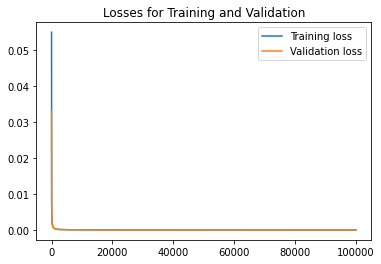

In [16]:
lstm_handler.plot_losses()

In [190]:
# Much higher loss because latitude and longitude outputs are being used as part of next inputs

actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim, feed_forward=True)
test_loss

0.007866322062909603

Text(0.5, 1.0, 'Losses for Training and Validation\n')

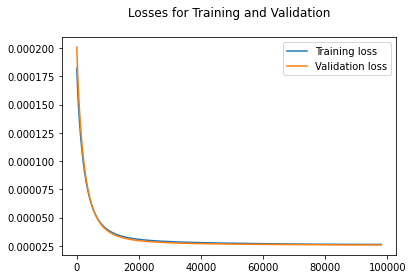

In [209]:
plt.plot(lstm_handler.train_losses[2000:], label="Training loss")
plt.plot(lstm_handler.val_losses[2000:], label="Validation loss")
plt.legend()
plt.title("Losses for Training and Validation\n")

Text(0.5, 1.0, 'Mean Distance Error for Training Dataset\n')

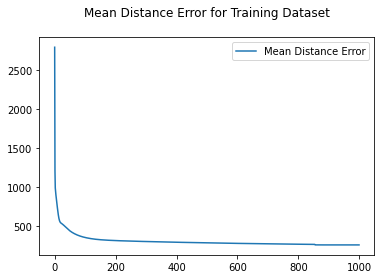

In [205]:
plt.plot(lstm_handler.distances[:], label="Mean Distance Error")
plt.legend()
plt.title("Mean Distance Error for Training Dataset\n")

In [ ]:
filename = './data/lstm_cell_model.pkl'
lstm_handler.save_model(filename)

In [321]:
# idx = np.where(test_ids == "AL052012")[0].item()
idx=51
print(idx)
id2 = test_ids[idx]
print(id2)
storm_len = df_data.loc[df_data.ID == id2].shape[0]
origin = df_data.loc[df_data.ID == id2][['LAT', 'LON']].iloc[0] / 10
lat_pred = predicted3d[idx, :storm_len-1, 0]
lon_pred = predicted3d[idx, :storm_len-1, 1]*-1
lat_actual = actual3d[idx, :storm_len-1, 0]
lon_actual = actual3d[idx, :storm_len-1, 1]*-1

lat_pred = np.insert(lat_pred, 0, origin[0])
lon_pred = np.insert(lon_pred, 0, origin[1]*-1)
lat_actual = np.insert(lat_actual, 0, origin[0])
lon_actual = np.insert(lon_actual, 0, origin[1]*-1)

51
AL071998


64

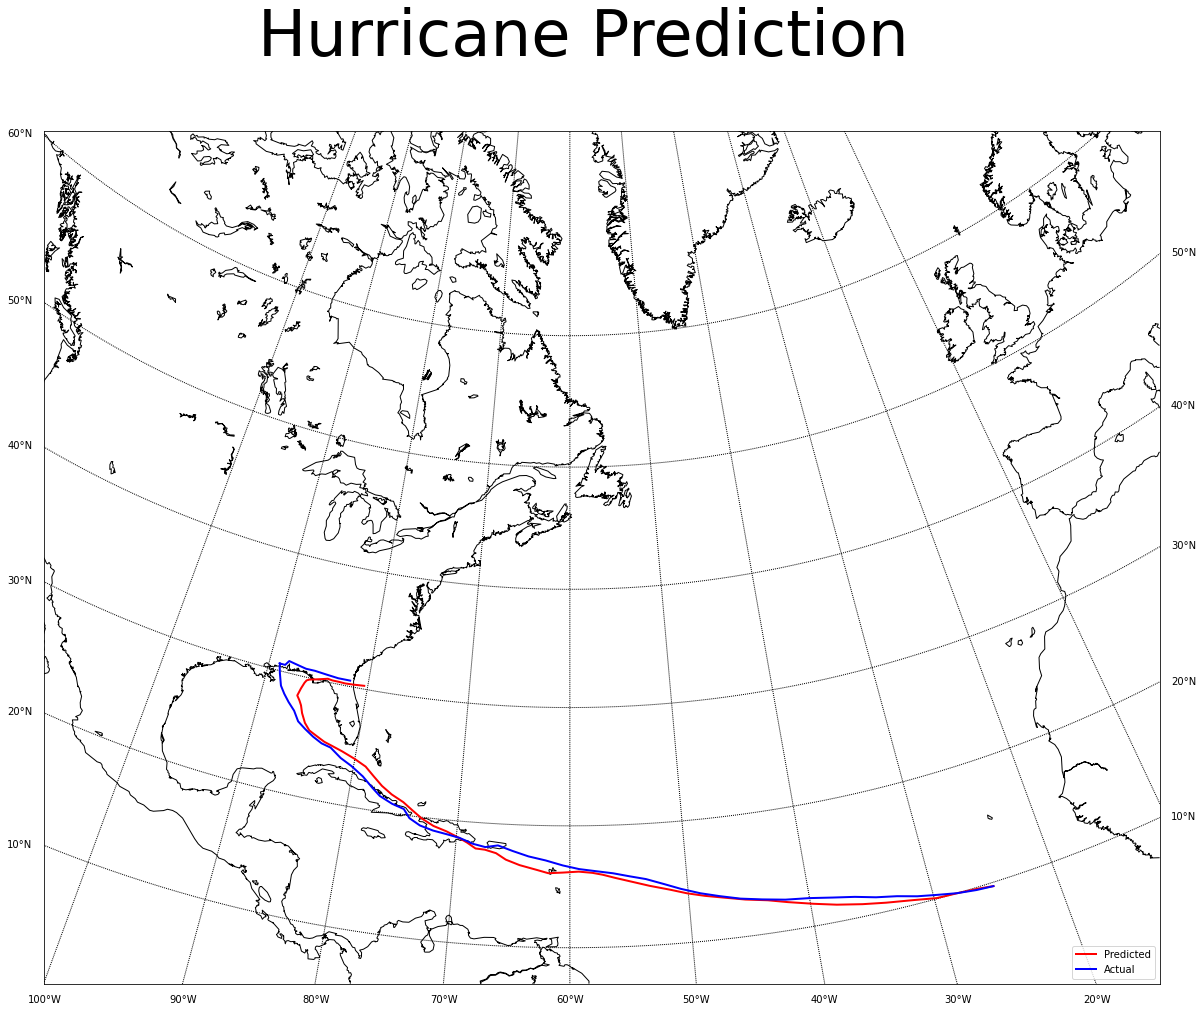

In [326]:
hurricane_map = map_hurricane("Hurricane Prediction")
lat_storm = lat_pred
lon_storm = lon_pred
x1, y1 = hurricane_map(lon_storm,lat_storm)
x2, y2 = hurricane_map(lon_actual, lat_actual)

#Prediction
plt.plot(x1,y1,'-',linewidth=2,color='red', label="Predicted")

#Actual
plt.plot(x2,y2,'-',linewidth=2,color='blue', label="Actual")

plt.legend(loc="lower right")

In [322]:
idx = 0
storm_lengths = []
for x in range(len(test_ids)):
    id2 = test_ids[idx]
    storm_len = df_data.loc[df_data.ID == id2].shape[0]
    storm_lengths.append(storm_len)
    idx += 1

In [323]:
df_testlen = pd.DataFrame(storm_lengths)
df_testlen = df_testlen.sort_values(by=[0])

81 LILI 2002 46
34 HORT 1996 49
37 ALLI 2001 50
32 HUGO 1989 50
4 LILI 1996 51
26 GORD 1994 54
56 IGOR 2010 54
75 EMIL 1993 59
51 GEOR 1998 64


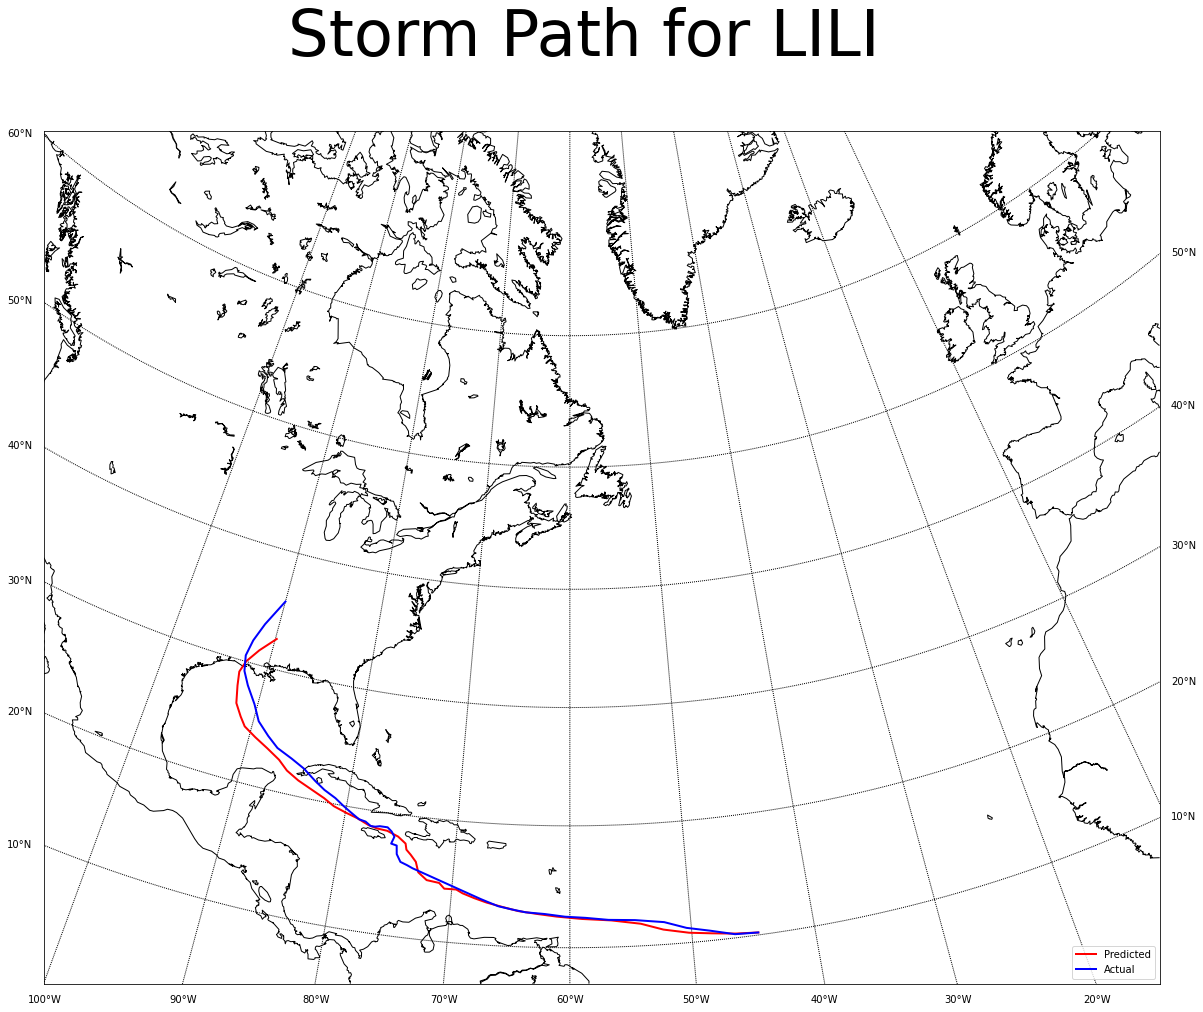

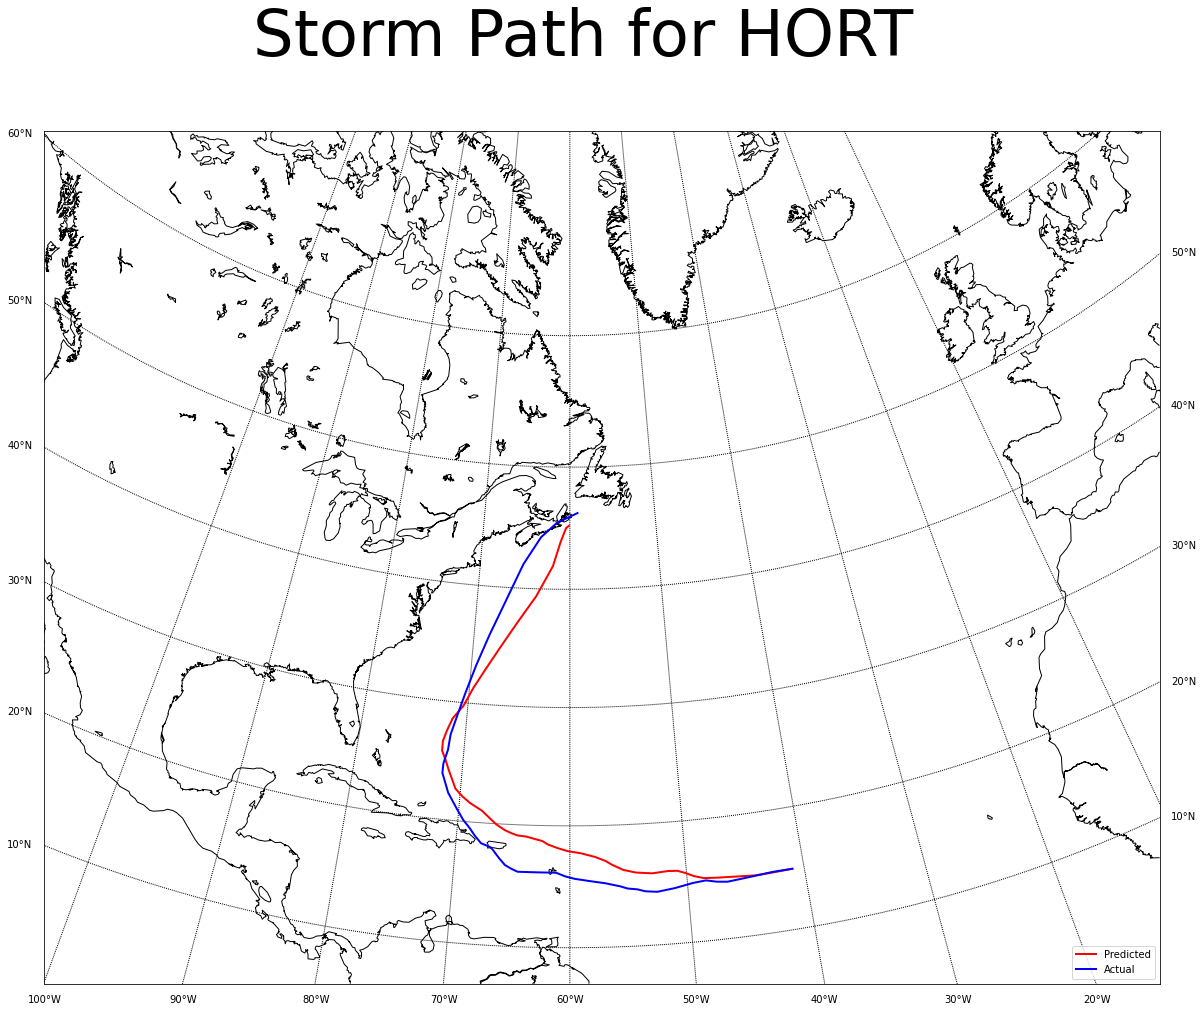

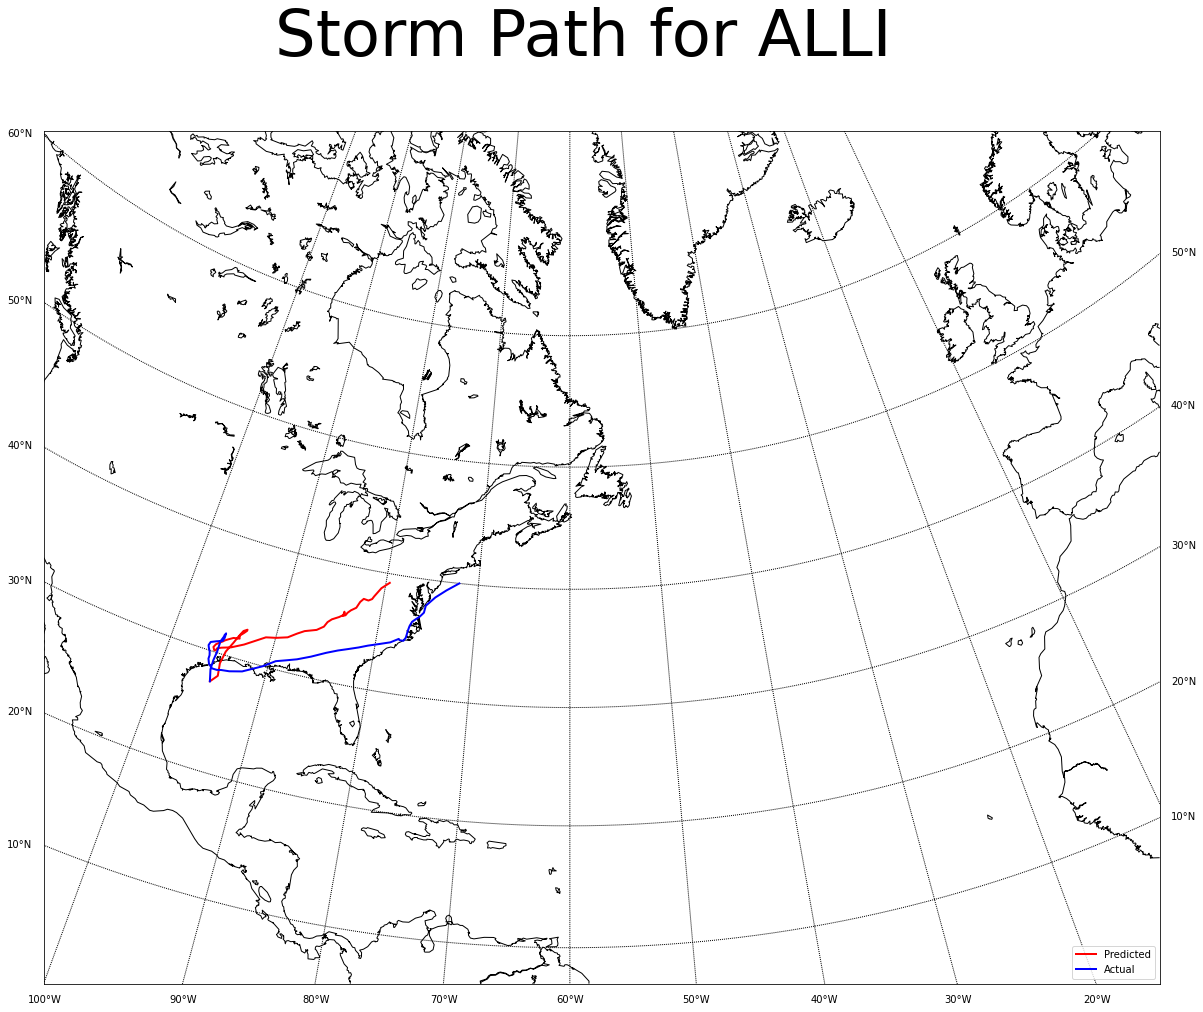

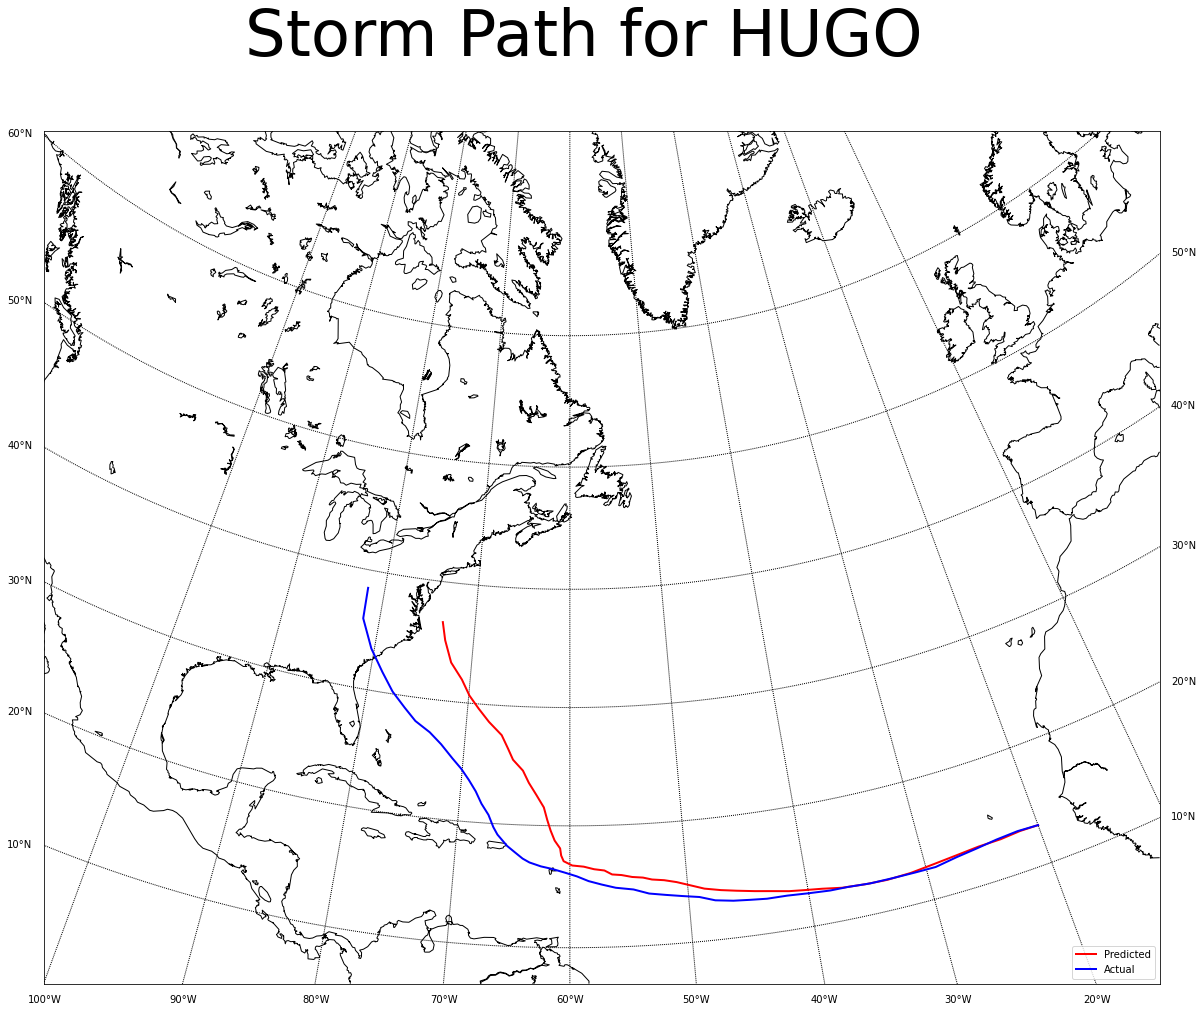

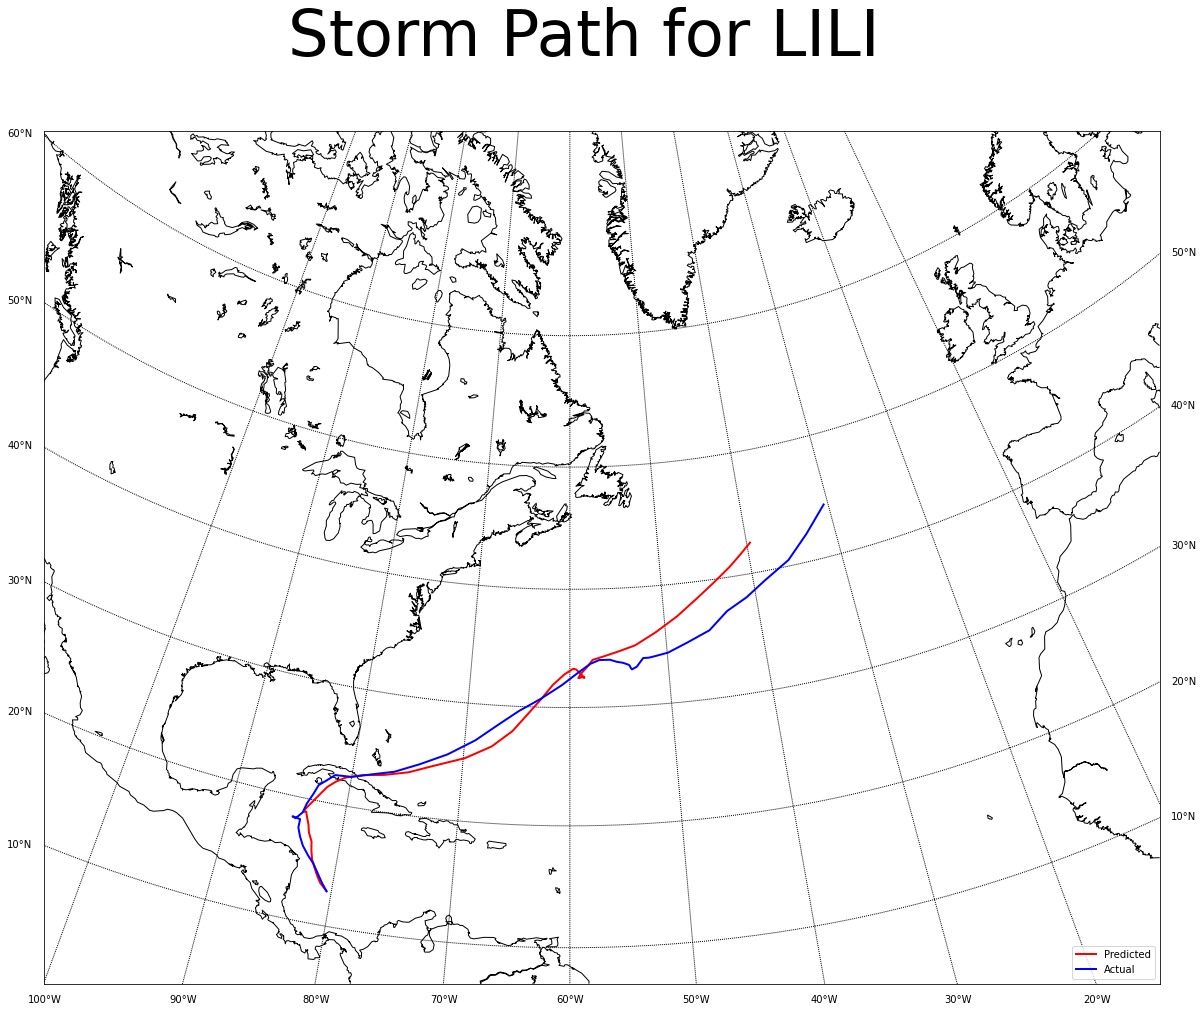

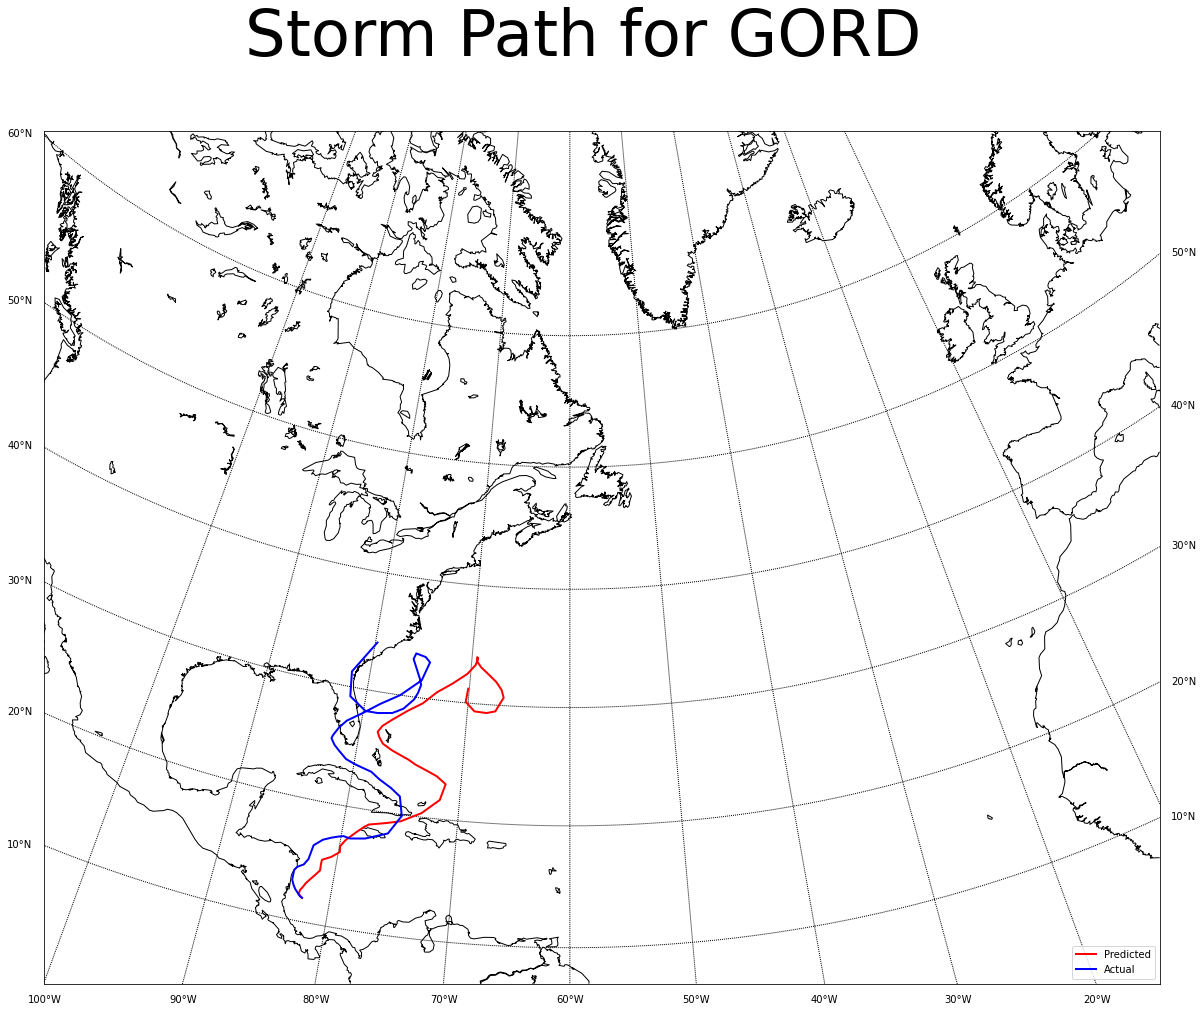

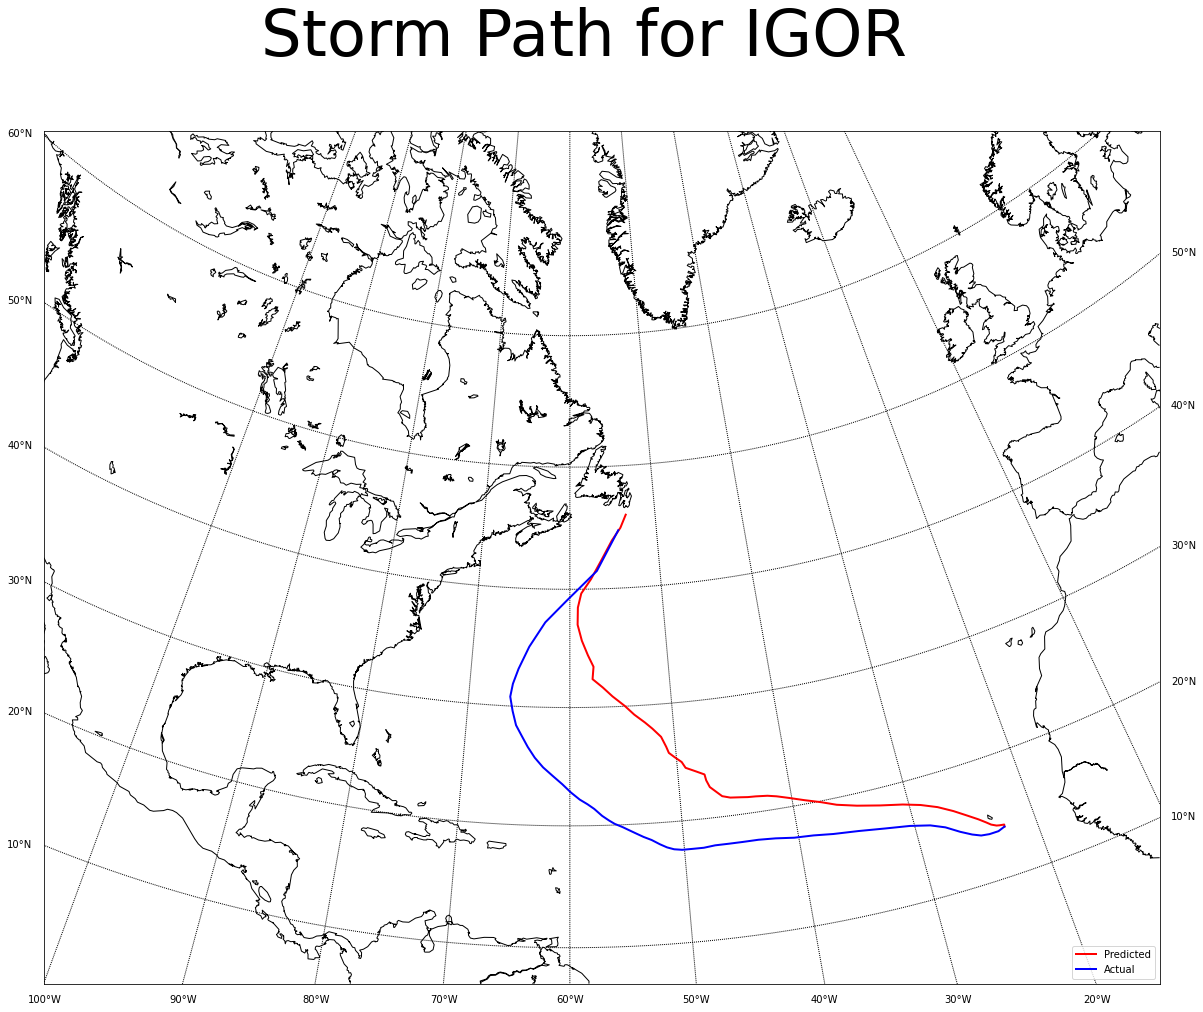

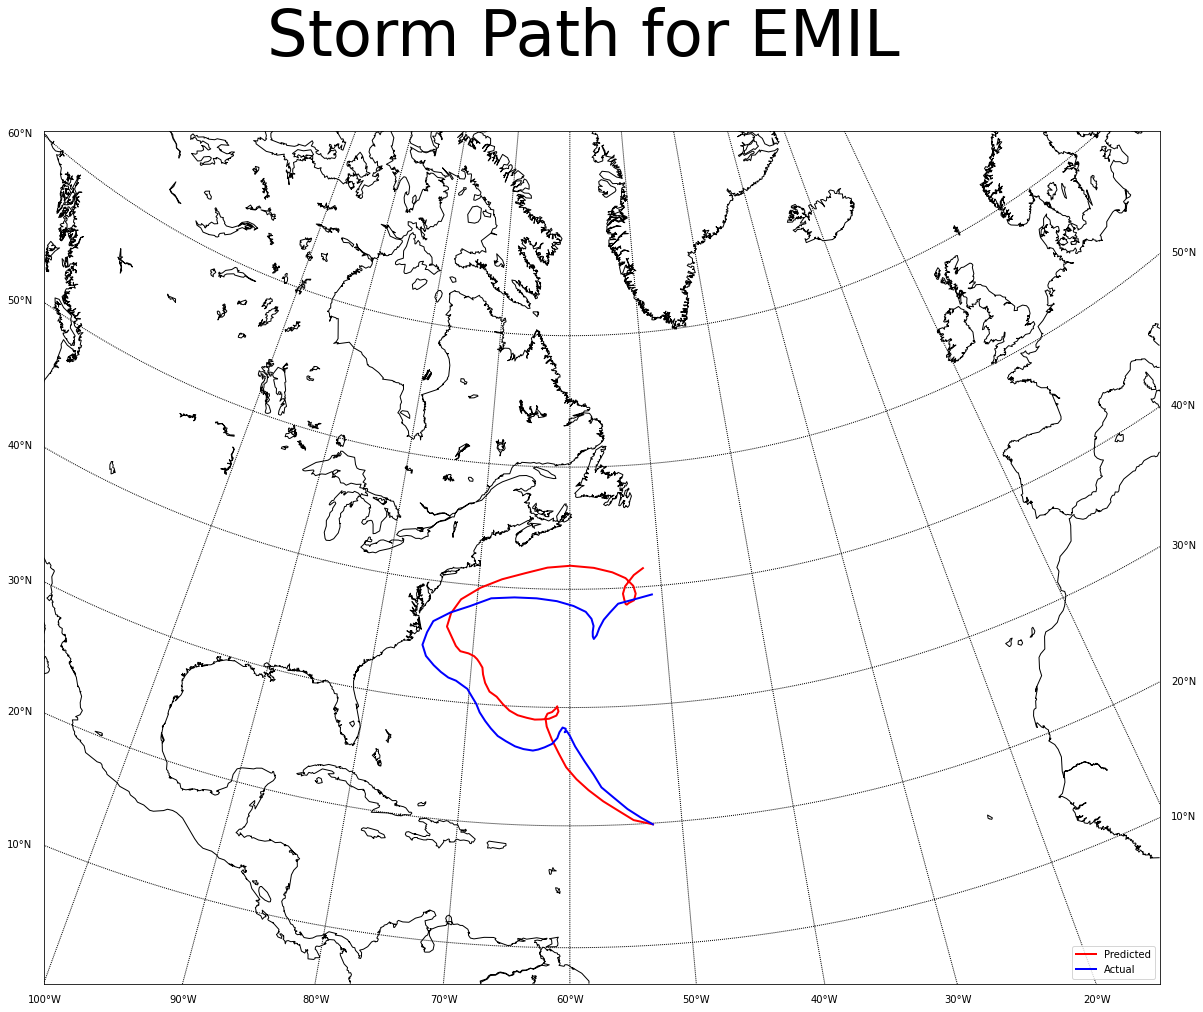

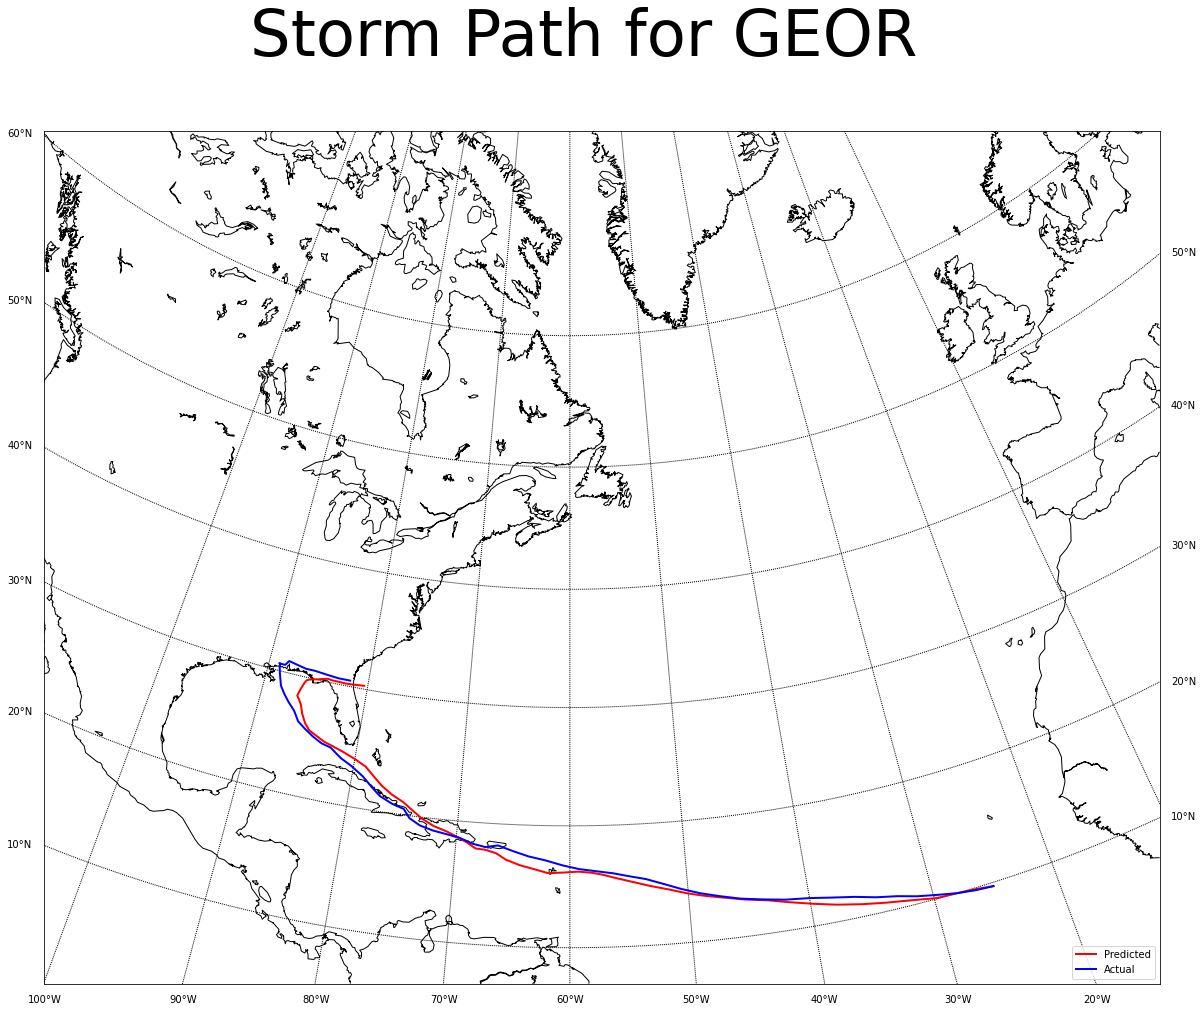

In [400]:
for index in np.array(df_testlen.tail(9).index):
    print(index, end=' ')
    idx=index
    id2 = test_ids[idx]
    name = df_data.loc[df_data.ID == id2]['NAME'].iloc[0]
    year = df_data.loc[df_data.ID == id2]['YEAR'].iloc[0]
    storm_len = df_data.loc[df_data.ID == id2].shape[0]
    print(name, year, storm_len)
    origin = df_data.loc[df_data.ID == id2][['LAT', 'LON']].iloc[0] / 10
    lat_pred = predicted3d[idx, :storm_len-1, 0]
    lon_pred = predicted3d[idx, :storm_len-1, 1]*-1
    lat_actual = actual3d[idx, :storm_len-1, 0]
    lon_actual = actual3d[idx, :storm_len-1, 1]*-1

    lat_pred = np.insert(lat_pred, 0, origin[0])
    lon_pred = np.insert(lon_pred, 0, origin[1]*-1)
    lat_actual = np.insert(lat_actual, 0, origin[0])
    lon_actual = np.insert(lon_actual, 0, origin[1]*-1)
    
    hurricane_map = map_hurricane("Storm Path for " + name)
    lat_storm = lat_pred
    lon_storm = lon_pred
    x1, y1 = hurricane_map(lon_storm,lat_storm)
    x2, y2 = hurricane_map(lon_actual, lat_actual)

    #Prediction
    plt.plot(x1,y1,'-',linewidth=2,color='red', label="Predicted")

    #Actual
    plt.plot(x2,y2,'-',linewidth=2,color='blue', label="Actual")

    plt.legend(loc="lower right")

In [ ]:
with torch.no_grad():
    batch = 0
    targets = []
    for data, target in train_loader:
        target2 = target.view(-1, 2)
        target2 = scaler.unnormalize(target2.cpu().detach().numpy())
        target2 /= 10
        target2 = np.reshape(target2, (-1, 89, 2))
        targets.append(target2)
    for data, target in val_loader:
        target2 = target.view(-1, 2)
        target2 = scaler.unnormalize(target2.cpu().detach().numpy())
        target2 /= 10
        target2 = np.reshape(target2, (-1, 89, 2))
        targets.append(target2)
    for data, target in test_loader:
        target2 = target.view(-1, 2)
        target2 = scaler.unnormalize(target2.cpu().detach().numpy())
        target2 /= 10
        target2 = np.reshape(target2, (-1, 89, 2))
        targets.append(target2)

In [ ]:
targets = np.concatenate(targets, axis=0)

In [22]:
ids = np.concatenate([train_ids, val_ids, test_ids], axis=0)

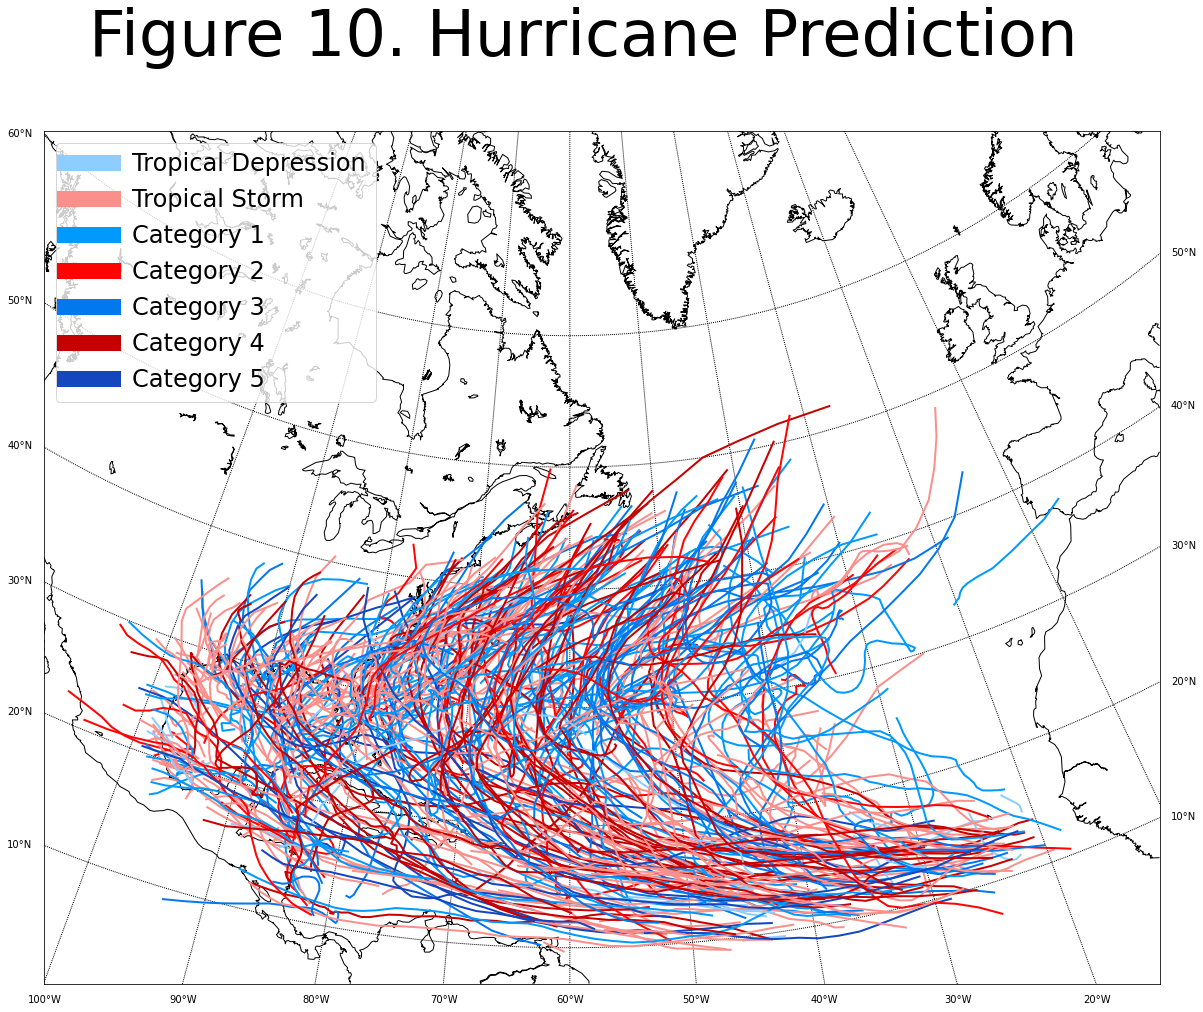

In [35]:
from matplotlib.lines import Line2D

def color_fn(cat):
    if cat == -1:
        return '#8dcdff'
    elif cat == 0:
        return '#fa8f8b'
    elif cat == 1:
        return '#009aff'
    elif cat == 2:
        return '#ff0303'
    elif cat == 3:
        return '#0278ee'
    elif cat == 4:
        return '#c60000'
    elif cat == 5:
        return '#1446bd'

hurricane_map = map_hurricane("Atlantic Hurricane Trajectories")

idx = 0
for hurricane in targets:
    id2 = ids[idx]
    storm_len = df_data.loc[df_data.ID == id2].shape[0]
    cat = max(df_data.loc[df_data.ID == id2]['CATEGORY'])
    x2, y2 = hurricane_map(hurricane[:storm_len-1, 1]*-1, hurricane[:storm_len-1, 0])
    plt.plot(x2,y2,'-',linewidth=2,color=color_fn(cat), label="Actual")
    idx += 1


custom_lines = [Line2D([0], [0], color='#8dcdff', lw=16),
                Line2D([0], [0], color='#fa8f8b', lw=16),
                Line2D([0], [0], color='#009aff', lw=16),
                Line2D([0], [0], color='#ff0303', lw=16),
                Line2D([0], [0], color='#0278ee', lw=16),
                Line2D([0], [0], color='#c60000', lw=16),
                Line2D([0], [0], color='#1446bd', lw=16)]

plt.legend(custom_lines, ['Tropical Depression', 'Tropical Storm', 'Category 1',
            'Category 2', 'Category 3', 'Category 4', 'Category 5'], prop={'size': 24}, loc='upper left')